/var/folders/5k/2f47wm290h3dff9gbv_1hbl00000gp/T/ipykernel_88835/1612870531.py:68: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M').sum()
14:02:58 - cmdstanpy - INFO - Chain [1] start processing
14:02:58 - cmdstanpy - INFO - Chain [1] done processing
/Users/matthias.wagner/miniconda3/envs/clean-kernel/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/matthias.wagner/miniconda3/envs/clean-kernel/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/matthias.wagner/miniconda3/envs/clean-kernel/li

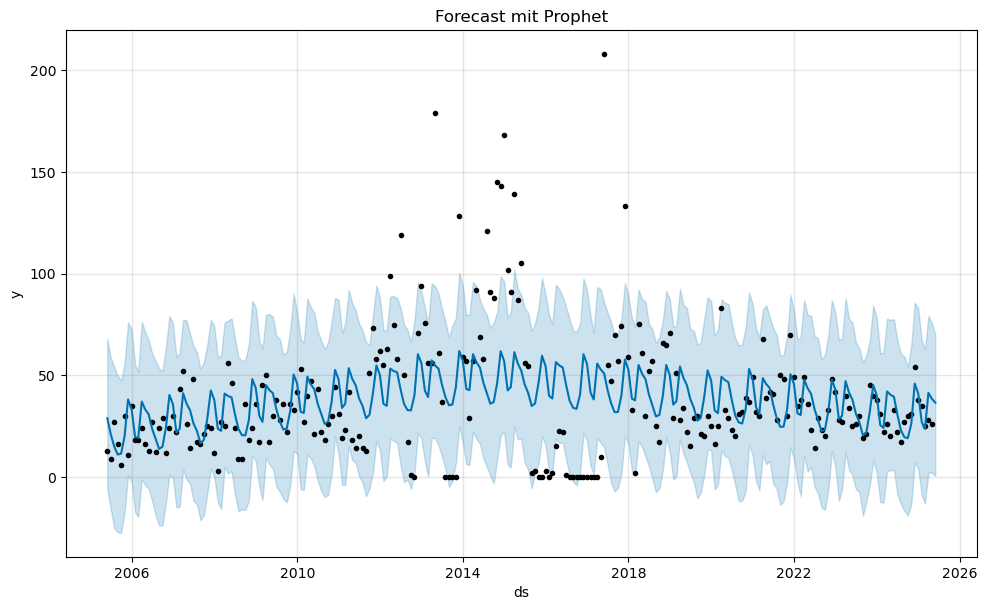

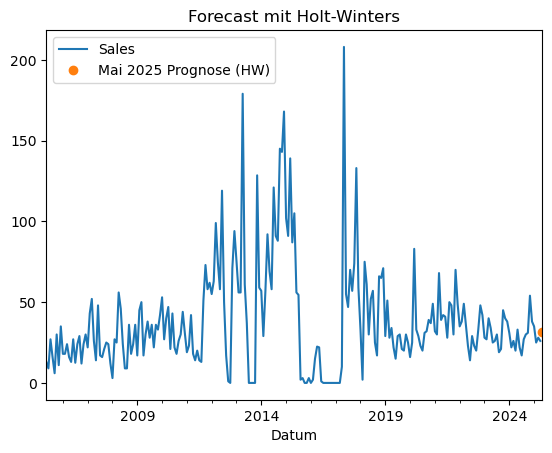

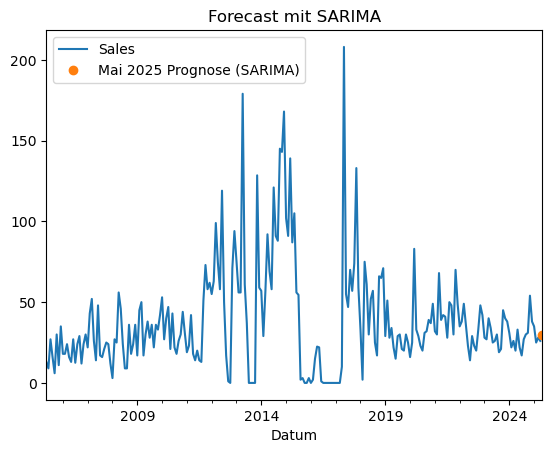


Einzelprognosen für Mai 2025:
Prophet: 36.52
Holt-Winters: 31.33
SARIMA: 29.53
Kombinierte Prognose: 32.46


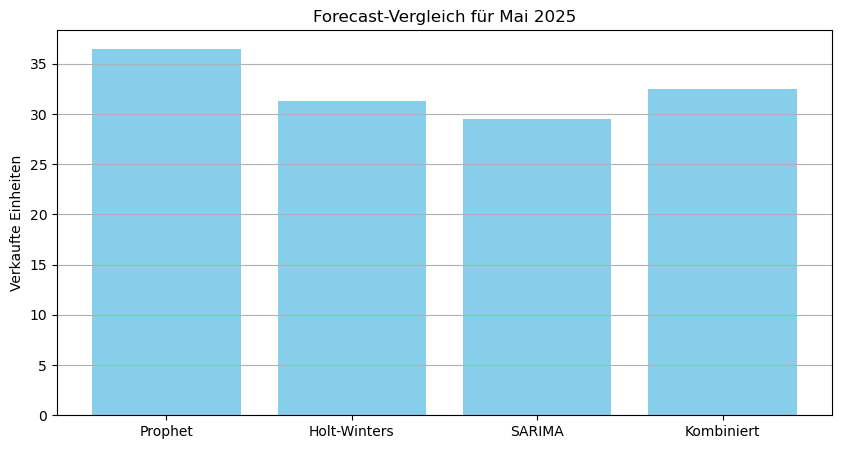

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import seaborn as sns

plt.rcdefaults()

# Setze explizit auf weißen Hintergrund
plt.style.use('default')
sns.set_style("white")  # oder "whitegrid"

# Weiß als explizite Farbe für alle Ebenen setzen
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'ytick.direction': 'out',
    'xtick.direction': 'out',
})


CSV_PATH = '../data/ananas.csv'
DATE_COLUMN_NAME = 'Datum'
SALES_COLUMN_NAME = 'Sales'
COLUMN_SEPARATOR = ';'
DECIMAL_SEPARATOR = ','
ENCODING_LATIN = 'latin-1'

# plt.style.use('seaborn-v0_8-white')      # Weißer Hintergrund
# plt.style.use('seaborn-v0_8-whitegrid')
plt.style.use('default')
sns.set_palette('deep')
plt.rcdefaults()  # Reset alle Einstellungen
plt.style.use('default')
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

df = pd.read_csv(CSV_PATH,
                 encoding=ENCODING_LATIN,
                 sep=COLUMN_SEPARATOR,
                 decimal=DECIMAL_SEPARATOR,
                 usecols=[DATE_COLUMN_NAME, SALES_COLUMN_NAME])

df.columns = df.columns.str.strip()
columns = df.columns.tolist()
date_column = columns[0]
sales_column = columns[1]

df[date_column] = pd.to_datetime(df[date_column], format='%d.%m.%Y')

df.set_index(date_column, inplace=True)

# Monatlich aggregieren
monthly = df.resample('M').sum()

# Nur bis April 2025
monthly = monthly[monthly.index < '2025-05-01']

### 1. Prophet ###
df_prophet = monthly.reset_index().rename(columns={date_column: "ds", sales_column: "y"})
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=1, freq='M')
forecast_prophet = model_prophet.predict(future)
may_2025_prophet = forecast_prophet[forecast_prophet['ds'].dt.strftime('%Y-%m') == '2025-05']['yhat'].values[0]

fig1 = model_prophet.plot(forecast_prophet)
plt.title("Forecast mit Prophet")
plt.show()

### 2. Holt-Winters ###
holt = ExponentialSmoothing(monthly, trend='add', seasonal='add', seasonal_periods=12)
hw_model = holt.fit()
hw_forecast = hw_model.forecast(1)
may_2025_hw = hw_forecast.iloc[0]

monthly.plot(label='Historisch')
hw_forecast.plot(style='o', label='Mai 2025 Prognose (HW)')
plt.title("Forecast mit Holt-Winters")
plt.legend()
plt.show()

### 3. SARIMA ###
sarima = SARIMAX(monthly, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model = sarima.fit(disp=False)
sarima_forecast = sarima_model.get_forecast(steps=1).predicted_mean
may_2025_sarima = sarima_forecast.iloc[0]

monthly.plot(label='Historisch')
sarima_forecast.plot(style='o', label='Mai 2025 Prognose (SARIMA)')
plt.title("Forecast mit SARIMA")
plt.legend()
plt.show()

### 4. Kombinierter Forecast ###
combined = np.mean([may_2025_prophet, may_2025_hw, may_2025_sarima])
print(f"\nEinzelprognosen für Mai 2025:")
print(f"Prophet: {may_2025_prophet:.2f}")
print(f"Holt-Winters: {may_2025_hw:.2f}")
print(f"SARIMA: {may_2025_sarima:.2f}")
print(f"Kombinierte Prognose: {combined:.2f}")

# Visualisierung kombiniert
plt.figure(figsize=(10, 5))
plt.bar(['Prophet', 'Holt-Winters', 'SARIMA', 'Kombiniert'], 
        [may_2025_prophet, may_2025_hw, may_2025_sarima, combined], color='skyblue')
plt.title("Forecast-Vergleich für Mai 2025")
plt.ylabel("Verkaufte Einheiten")
plt.grid(axis='y')
plt.show()
